$L_{generative}=(x-G_\phi(z))^2$  
$z^*=\underset{z}{\operatorname{argmin}}(L_{generative})$  
$L_{target}=(y-F_\theta(z^*))^2$  
$\theta^*, \phi^*=\underset{\theta, \phi}{\operatorname{argmin}}(L_{target})$

for $m = 1\dots M:$  
&nbsp;&nbsp;&nbsp;&nbsp; $L_{generative}=(x-G_{\phi_{m-1}}(z))^2$  
&nbsp;&nbsp;&nbsp;&nbsp; for $n = 1\dots N:$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $z_n=z_{n-1}-\alpha \frac{\mathrm d}{\mathrm d z}\big(L_{generative}\big)$  
&nbsp;&nbsp;&nbsp;&nbsp; $z^*=z^N$  
&nbsp;&nbsp;&nbsp;&nbsp; $L_{target}=(y-F_\theta(z^*))^2$  
&nbsp;&nbsp;&nbsp;&nbsp; $\theta_{m}=\theta_{m-1}-\beta\frac{\mathrm d}{\mathrm d \theta}\big(L_{target}\big)$  
&nbsp;&nbsp;&nbsp;&nbsp; $\phi_{m}=\phi_{m-1}-\gamma\frac{\mathrm d}{\mathrm d \phi}\big(L_{target}\big)$  
$\theta^*=\theta^M$  
$\phi^*=\phi^M$  

<img src="https://github.com/arturmiller/MachineLearning/blob/master/notebooks/images/inverse_net.png?raw=true" style="width: 30%;"/>  

In [20]:
import numpy as np
import tensorflow as tf

class InverseNet(object):
    def __init__(self, num_latent_params=10, learning_rate=5e-4, seed=42, iter_inner_loop=500, iter_outer_loop=50):
        self.num_latent_params = num_latent_params
        self.learning_rate = learning_rate

        np.random.seed(seed)
        self.loss_history = []
        self.iter_inner_loop = iter_inner_loop
        self.iter_outer_loop = iter_outer_loop

    def tf_gen_model(self, latent_params, model_params, X):
        tf_output = tf.transpose(tf.matmul(model_params, latent_params))
        loss = tf.sqrt(tf.nn.l2_loss(tf_output - X))
        grad = tf.gradients(loss, [latent_params])[0]

        next_latent_params = latent_params - tf.multiply(0.01, grad)
        return next_latent_params

    def tf_iter_latent_params(self, X, latent_params, model_params):
        for i in range(self.iter_inner_loop):
            latent_params = self.tf_gen_model(latent_params, model_params, X)
        return latent_params

    def tf_calc_outer_loss(self, X, y, latent_params, model_params):
        latent_params = self.tf_iter_latent_params(X, latent_params, model_params)
        loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=tf.transpose(latent_params))
        return loss

    def fit(self, X, y):
        latent_shape = (self.num_latent_params, np.size(X, axis=0))
        tf_latent_params = tf.constant(np.abs(np.random.randn(*latent_shape)) / 100.0, dtype=tf.float32)
        tf_y = tf.constant(y, dtype=tf.float32)


        model_shape = (np.size(X, axis=1), self.num_latent_params)
        tf_model_params = tf.Variable(np.abs(np.random.randn(*model_shape)) / 100.0, dtype=tf.float32)#, constraint=positive)

        tf_X = tf.constant(X, dtype=tf.float32)
        L2 = self.tf_calc_outer_loss(tf_X, tf_y, tf_latent_params, tf_model_params)
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        train = optimizer.minimize(L2)

        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)

        def eval_step(i=0):
            tmp_loss = sess.run(L2)
            self.loss_history.append(tmp_loss)
            print_loss_number = int(self.iter_outer_loop / 20)
            if i % print_loss_number == 0:
                print('index: {} loss: {}'.format(i, tmp_loss), end='\r')

        for i in range(self.iter_outer_loop):
            eval_step(i)
            sess.run(train)

        self.model_params = sess.run(tf_model_params)

    def predict(self, X):
        tf_X = tf.constant(X, dtype=tf.float32)
        latent_shape = (self.num_latent_params, np.size(X, axis=0))
        tf_latent_params = tf.constant(np.abs(np.random.randn(*latent_shape)) / 100.0, dtype=tf.float32)
        tf_model_params = tf.constant(self.model_params, dtype=tf.float32)
        tf_res_latent_params = self.tf_iter_latent_params(tf_X, tf_latent_params, tf_model_params)
        tf_label = tf.argmax(tf_res_latent_params, axis=0)
        sess = tf.Session()
        label = sess.run(tf_label)
        return label

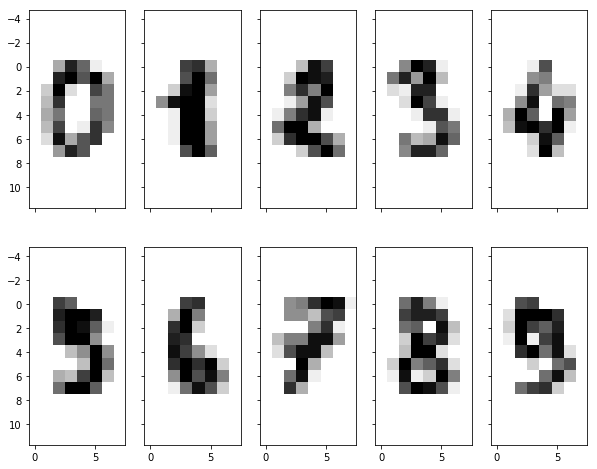

In [21]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pylab as plt

digits = datasets.load_digits(10)

def plot_digits(images):
    f, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(10, 8))

    for i in range(2):
        for j in range(5):
            ax[i, j].imshow(
                images[i * 5 + j, :].reshape(8, 8), cmap='gray_r')
    plt.show()
plot_digits(digits.images)

index: 190 loss: 0.16452671587467194
accuracy: 61.2%


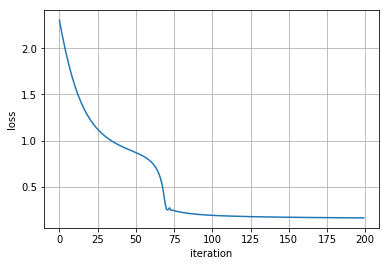

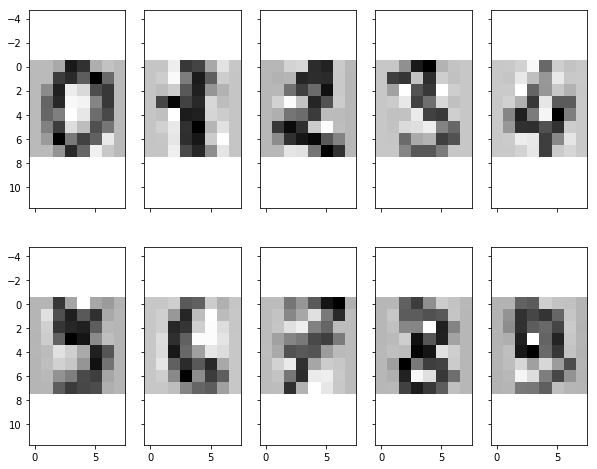

In [22]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(10, sparse=False)

def plot_loss(loss):
    plt.plot(loss)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('loss')

def train_data(num_train, learning_rate, iter_outer_loop):
    n_samples = len(digits.images)
    data = digits.images.reshape((n_samples, -1))
    loss_net = InverseNet(learning_rate=learning_rate, iter_inner_loop=250, iter_outer_loop=iter_outer_loop)
    X = data[:num_train, :]
    y = enc.fit_transform(digits.target[:num_train].reshape((-1, 1)))
    loss_net.fit(X, y)
    predicted = loss_net.predict(data[1000:1500, :])
    accuracy = np.sum(digits.target[1000:1500] == predicted)
    print('\naccuracy: {}%'.format(accuracy/5.0))
    
    plot_loss(loss_net.loss_history)
    plot_digits(loss_net.model_params.T)
    plt.show()
    
train_data(10, 1e1, 200)

index: 1900 loss: 1.7542099952697754
accuracy: 91.2%


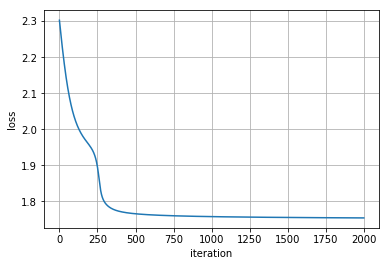

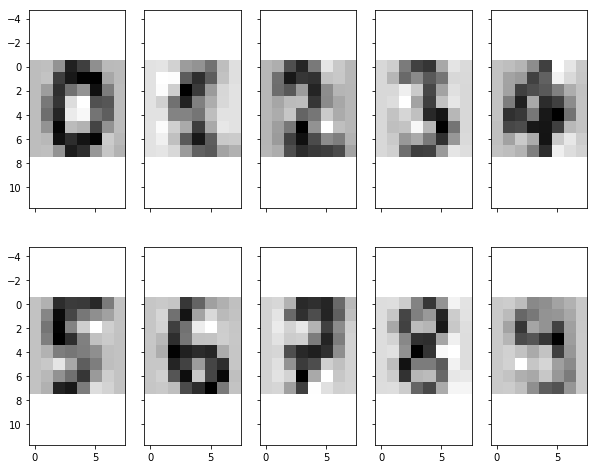

In [18]:
train_data(1000, 1e2, 2000)